### Modelling

In [ ]:
# Sampling libraries
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from Eda import *
from sklearn.utils import resample

# sklearn packages for Decision Tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
from sklearn.metrics import roc_auc_score

# sklearn packages for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import StandardScaler

# sklearn packages for KNNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# sklearn packages for NN
from sklearn.neural_network import MLPClassifier

# Set print options
pd.set_option('display.max_columns', None)

from tqdm import tqdm

In [2]:
df = df[['address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'famsup', 'famrel', 'G3']]

X = df.drop('G3', axis=1).values
y = df['G3'].values

x_boys = df_boys.drop('G3', axis=1).values
y_boys = df_boys['G3'].values

x_girls = df_girls.drop('G3', axis=1).values
y_girls = df_girls['G3'].values

In [3]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1).item()
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1).item()
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1).item()
    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr').item()

    # Return the results
    return {
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_roc
    }

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(x_boys, y_boys, test_size=0.2, random_state=42)
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(x_girls, y_girls, test_size=0.2, random_state=42)

splitList = [[X_train, y_train, X_test, y_test], [X_train_b, y_train_b, X_test_b, y_test_b], [X_train_g, y_train_g, X_test_g, y_test_g]]

In [5]:
# plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [26]:
def fitModel(model):
	results = []
	feature_importances = []
	for split in splitList:
		model.fit(split[0], split[1])
		results.append((model, split[2], split[3]))
		feature_importances.append(model.feature_importances_)
	return results, feature_importances

In [50]:
def scalerFitModel(model):
    results = []
    permutation_importances = []
    for split in splitList:
        scaler = StandardScaler()
        scaler.fit(split[0])
        X_train_std = scaler.transform(split[0])
        X_test_std = scaler.transform(split[2])
        model.fit(X_train_std, split[1])
        results.append((model, X_test_std, split[3]))
        result = permutation_importance(model, X_test_std, split[3], scoring='accuracy')
        permutation_importances.append(result.importances_mean)
    return results, permutation_importances

In [8]:
def evaluateModel(models):
    results = []
    for prediction in models:
        results.append(evaluate_model(prediction[0], prediction[1], prediction[2]))
    return results

In [22]:
def predictModel(model):
    results = []
    for split in splitList:
        results.append(model.predict(split[2]))
    return results

In [10]:
def plot_feature_importance(featImportLst, extraTitle = ''):
    fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
    fig.suptitle(f'{extraTitle} Feature Importance for Different Dataframes')

    features = df[['address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'guardian', 'traveltime', 'famsup', 'famrel']].columns
    importances = featImportLst
    indices = np.argsort(importances)

    ax.barh(features[indices], importances[indices])
    ax.set(xlabel='Importance', ylabel='Feature', title='Feature Importance')

    fig.tight_layout()
    plt.show()

In [11]:
def returnGender(split):
    return 'Combined' if split is splitList[0] else 'Male' if split is splitList[1] else 'Female'

#### Decision tree

In [43]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=df.columns.size - 2)
clf_models = fitModel(clf)
clf_evals = evaluateModel(clf_models[0])
clf_predictions = predictModel(clf)
clf_evals

[{'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.5563380281690141,
  'Precision': 0.5693528040896605,
  'Recall': 0.5563380281690141,
  'F1 Score': 0.5565511592419307,
  'AUC': 0.7224245844311634},
 {'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.26229508196721313,
  'Precision': 0.2702123695976155,
  'Recall': 0.26229508196721313,
  'F1 Score': 0.2634192037470726,
  'AUC': 0.5012584970531698},
 {'Model': 'DecisionTreeClassifier',
  'Accuracy': 0.25609756097560976,
  'Precision': 0.28439024390243905,
  'Recall': 0.25609756097560976,
  'F1 Score': 0.2656359645681207,
  'AUC': 0.4875749668512409}]

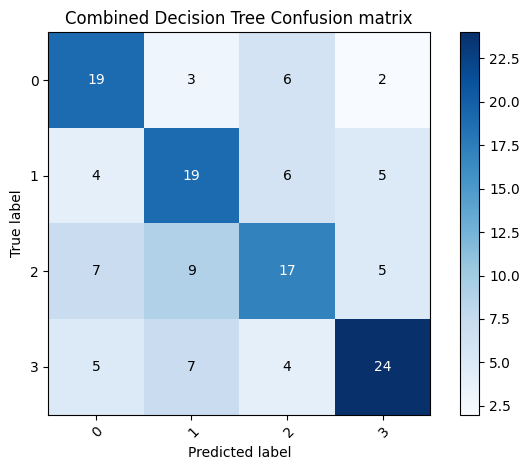

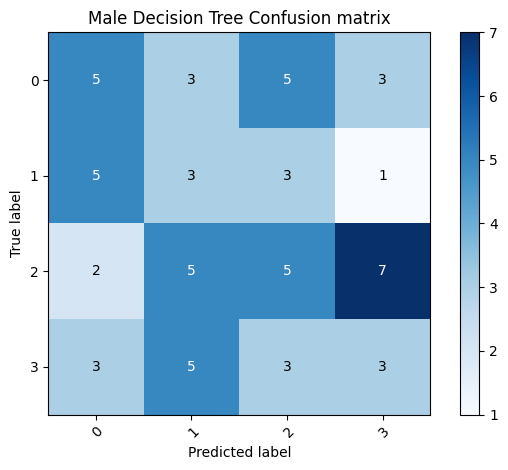

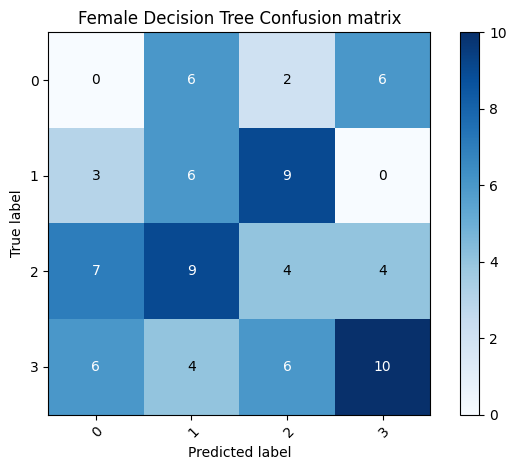

In [32]:
for s, p in zip(splitList, clf_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} Decision Tree Confusion matrix')
    plt.show()

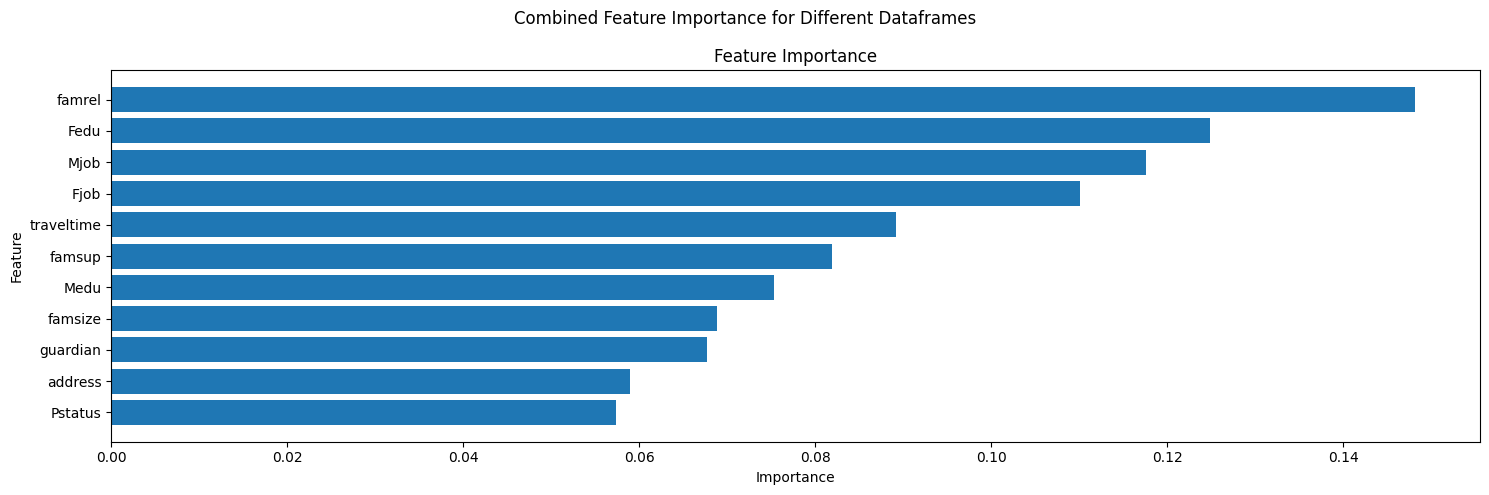

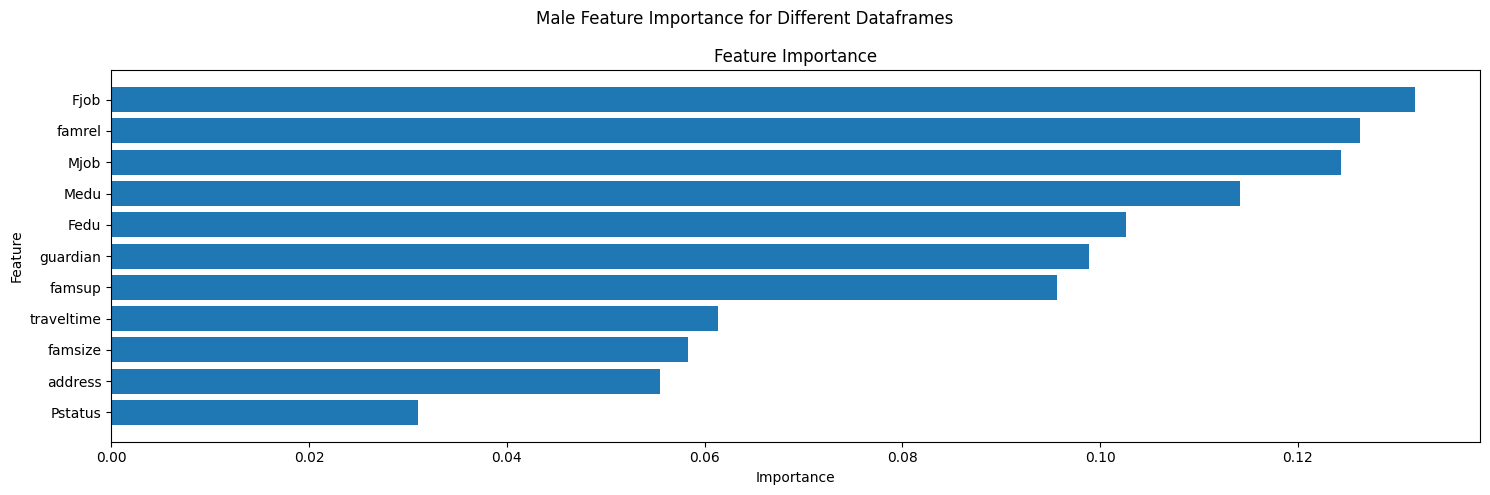

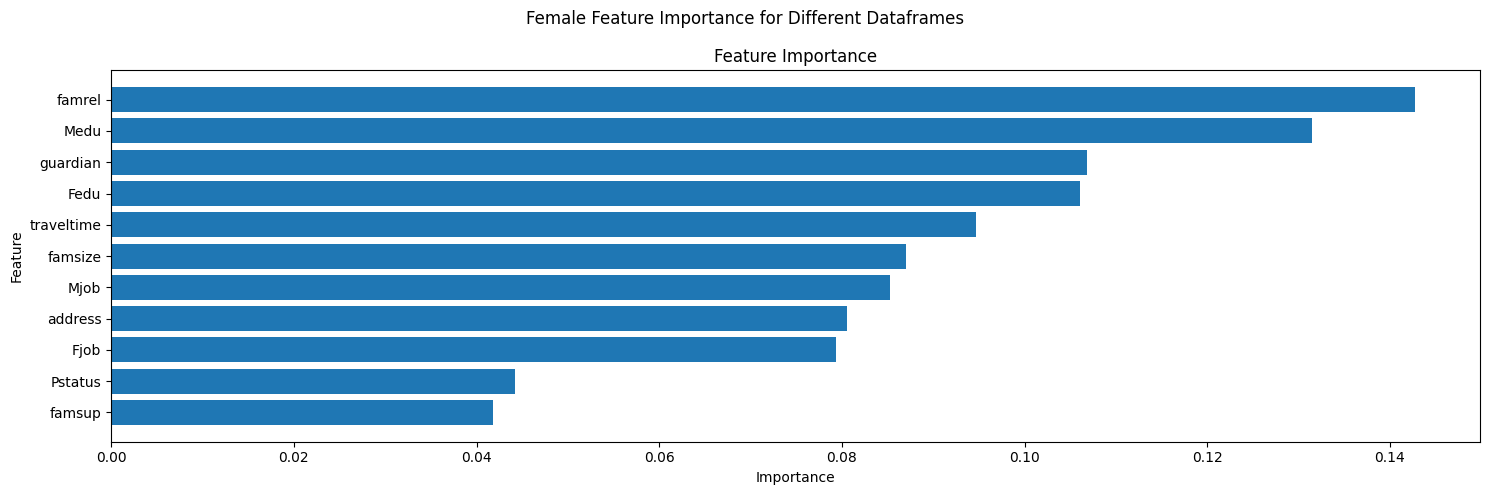

In [39]:
for s, m in zip(splitList, clf_models[1]):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### Random Forest

In [ ]:
rf = RandomForestClassifier()
rf_models = fitModel(rf)
rf_predictions = predictModel(rf)
rf_evals = evaluateModel(rf_models[0])
rf_evals

[{'Model': 'RandomForestClassifier',
  'Accuracy': 0.6408450704225352,
  'Precision': 0.640553548564112,
  'Recall': 0.6408450704225352,
  'F1 Score': 0.6382171818791538,
  'AUC': 0.8573956543649848},
 {'Model': 'RandomForestClassifier',
  'Accuracy': 0.32786885245901637,
  'Precision': 0.3225136612021858,
  'Recall': 0.32786885245901637,
  'F1 Score': 0.32090041106434547,
  'AUC': 0.5970032572566167},
 {'Model': 'RandomForestClassifier',
  'Accuracy': 0.36585365853658536,
  'Precision': 0.3743089430894309,
  'Recall': 0.36585365853658536,
  'F1 Score': 0.3689764612932871,
  'AUC': 0.5574129052731835}]

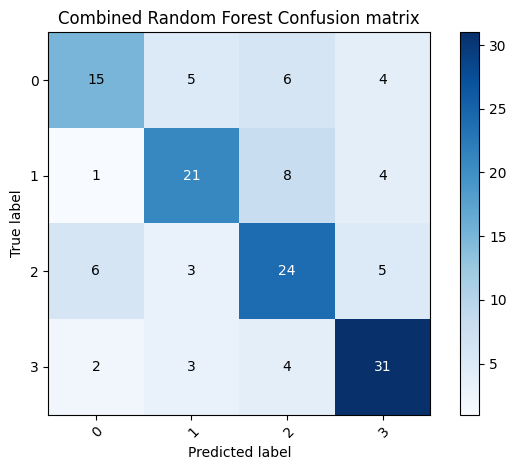

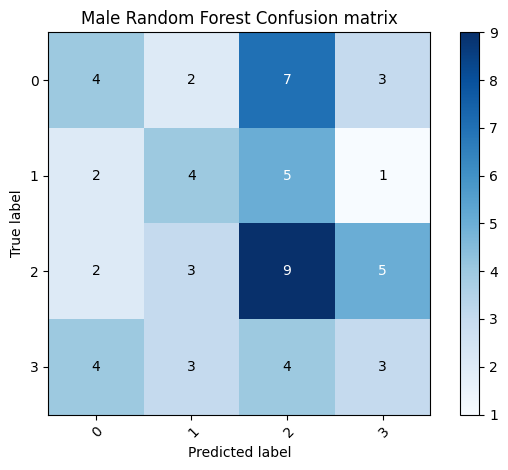

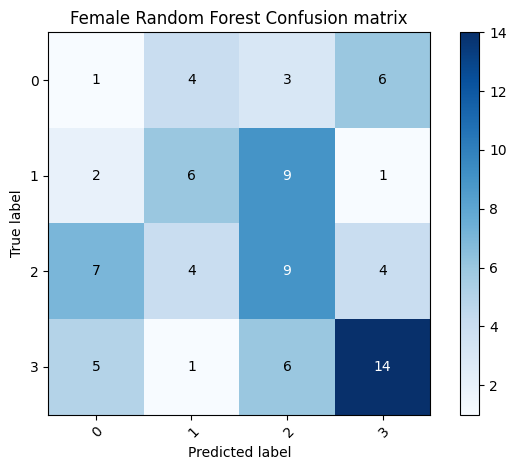

In [41]:
for s, p in zip(splitList, rf_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} Random Forest Confusion matrix')
    plt.show()

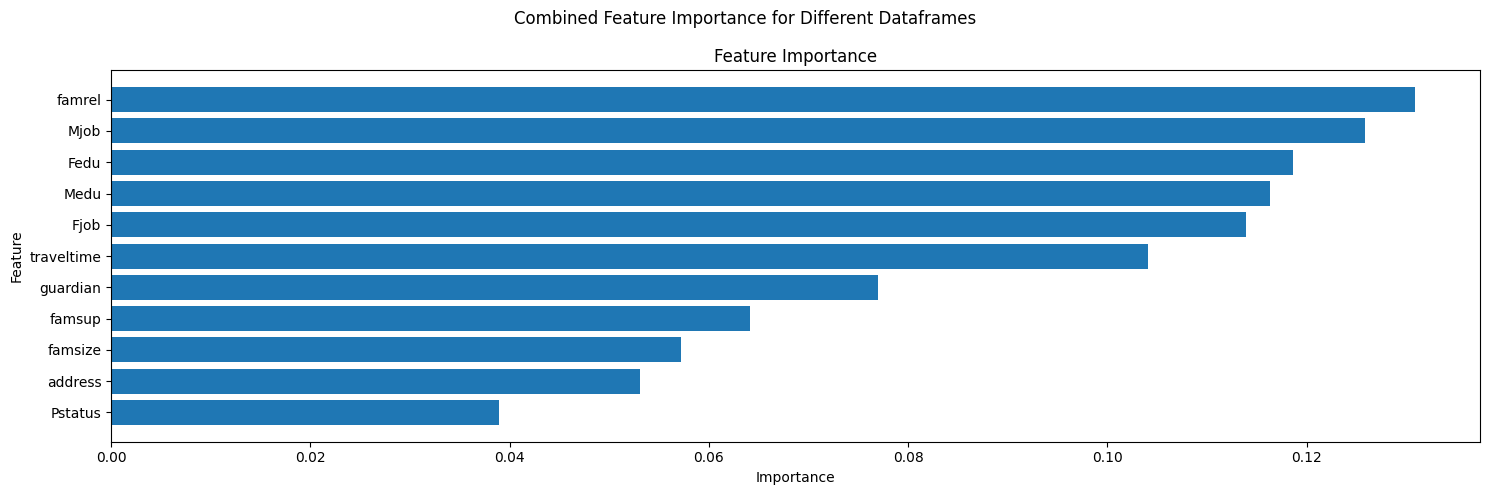

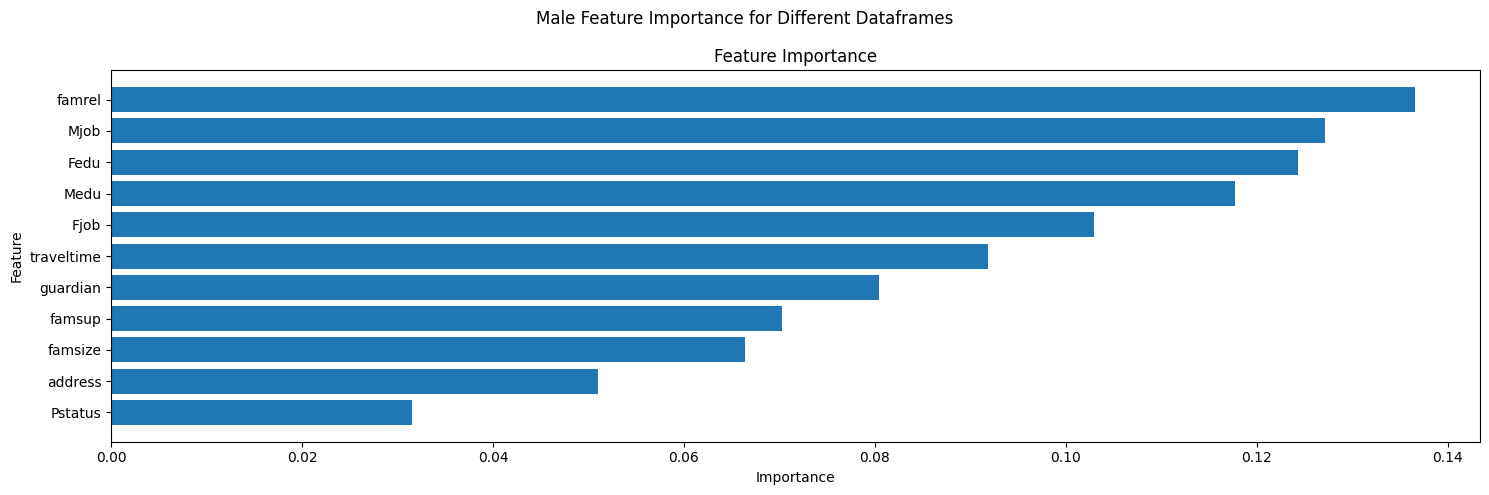

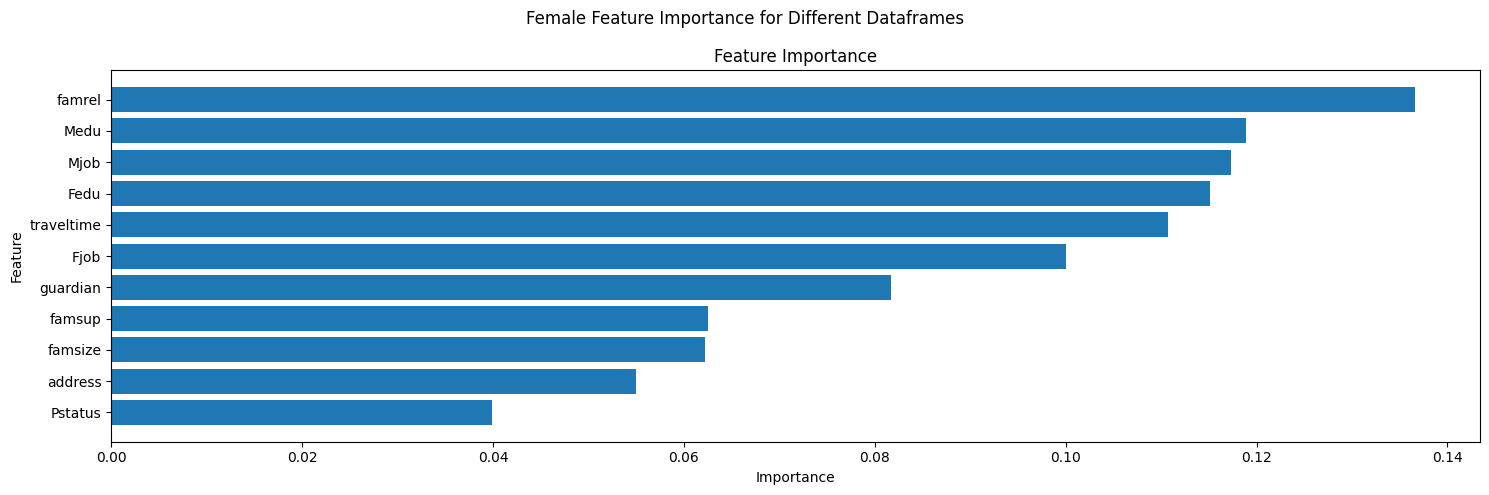

In [42]:
for s, m in zip(splitList, rf_models[1]):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

knn_models = scalerFitModel(knn)
knn_predictions = predictModel(knn)
knn_evals = evaluateModel(knn_models[0])
knn_evals

[{'Model': 'KNeighborsClassifier',
  'Accuracy': 0.6267605633802817,
  'Precision': 0.6266810167352498,
  'Recall': 0.6267605633802817,
  'F1 Score': 0.6227652863440629,
  'AUC': 0.8082116309186743},
 {'Model': 'KNeighborsClassifier',
  'Accuracy': 0.2786885245901639,
  'Precision': 0.26207800556884453,
  'Recall': 0.2786885245901639,
  'F1 Score': 0.26882112149166615,
  'AUC': 0.504258719398547},
 {'Model': 'KNeighborsClassifier',
  'Accuracy': 0.34146341463414637,
  'Precision': 0.34064258911819884,
  'Recall': 0.34146341463414637,
  'F1 Score': 0.3406599713055954,
  'AUC': 0.49055956448118593}]

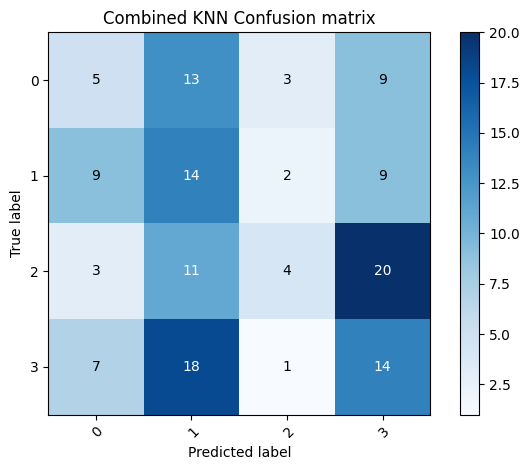

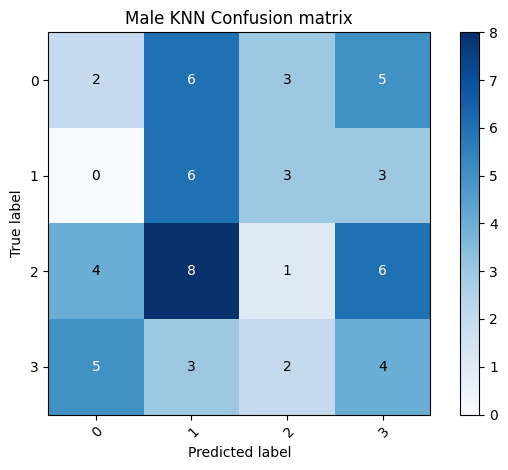

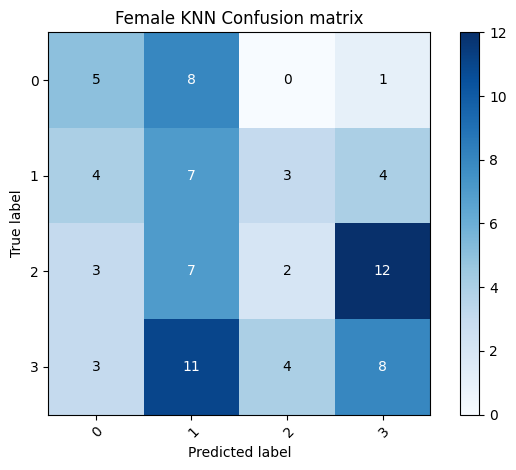

In [52]:
for s, p in zip(splitList, knn_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} KNN Confusion matrix')
    plt.show()

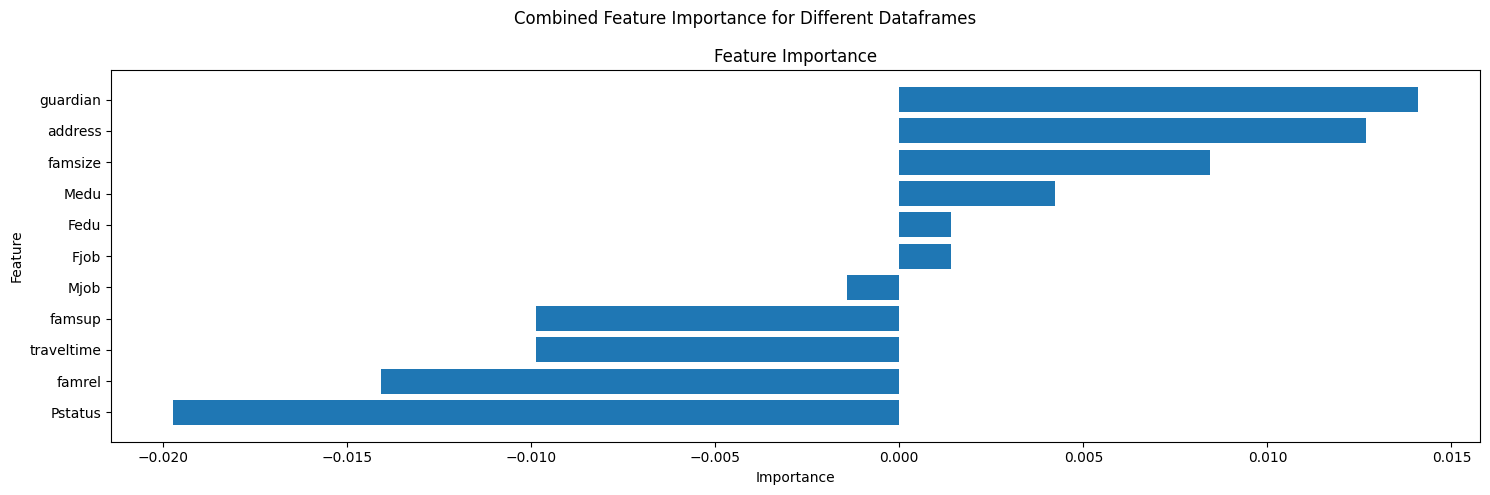

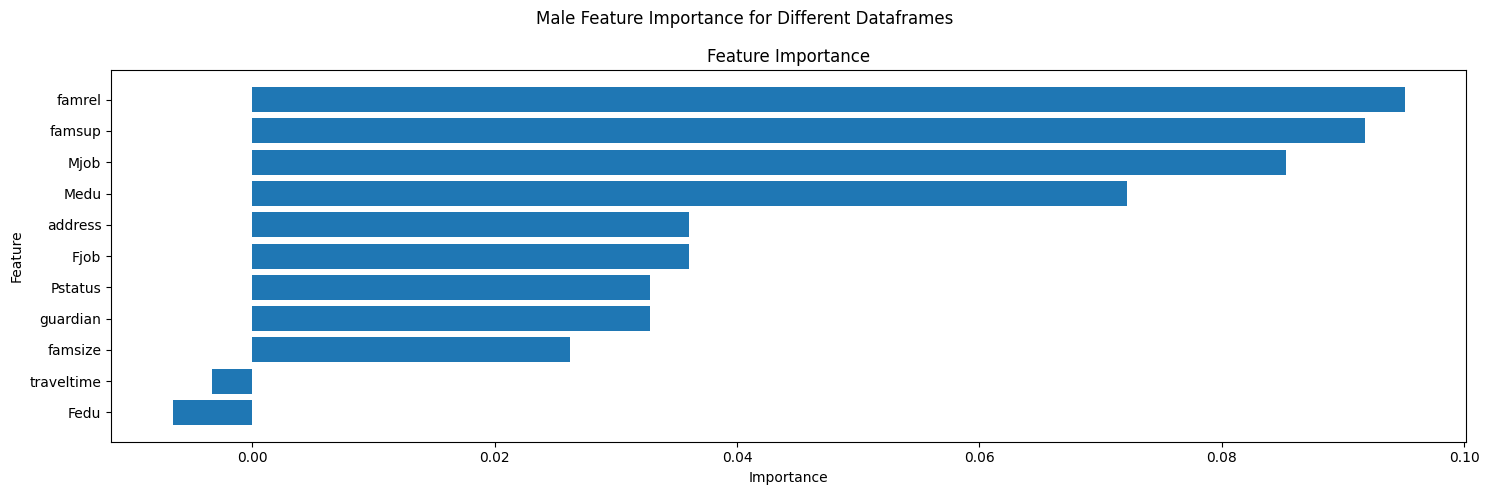

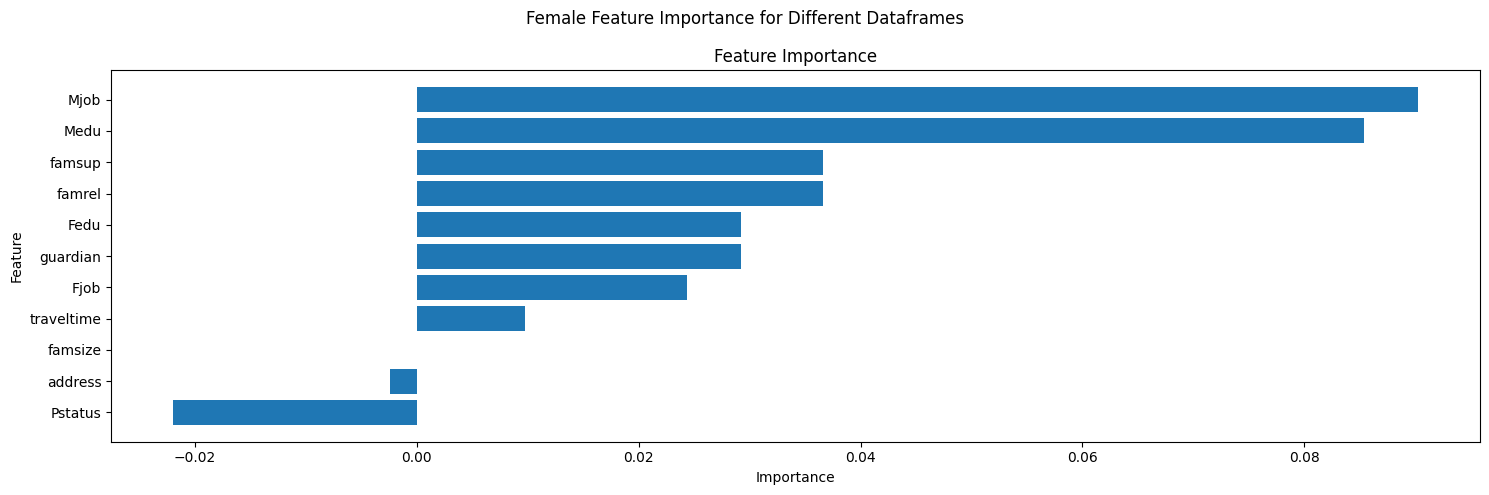

In [53]:
for s, m in zip(splitList, knn_models[1]):
    plot_feature_importance(m, extraTitle=returnGender(s))

In [57]:
nn = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=10000, activation='logistic', solver='lbfgs', learning_rate='adaptive')

nn_models = scalerFitModel(nn)
nn_predictions = predictModel(nn)
nn_evals = evaluateModel(nn_models[0])
nn_evals

[{'Model': 'MLPClassifier',
  'Accuracy': 0.5985915492957746,
  'Precision': 0.5964227191012631,
  'Recall': 0.5985915492957746,
  'F1 Score': 0.5965715616149291,
  'AUC': 0.786175434383155},
 {'Model': 'MLPClassifier',
  'Accuracy': 0.39344262295081966,
  'Precision': 0.38485558157689304,
  'Recall': 0.39344262295081966,
  'F1 Score': 0.3885245901639344,
  'AUC': 0.5775496158709844},
 {'Model': 'MLPClassifier',
  'Accuracy': 0.35365853658536583,
  'Precision': 0.34996873045653537,
  'Recall': 0.35365853658536583,
  'F1 Score': 0.3512653872620231,
  'AUC': 0.5348194269142228}]

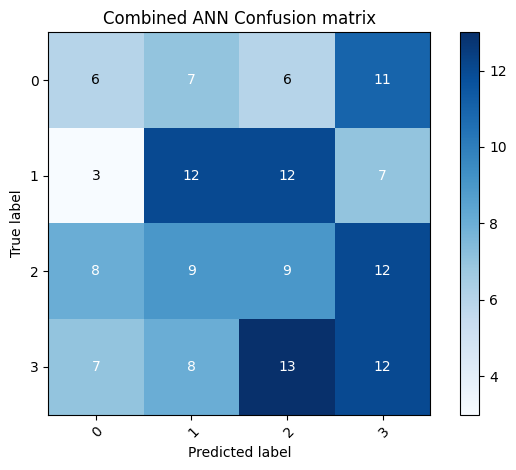

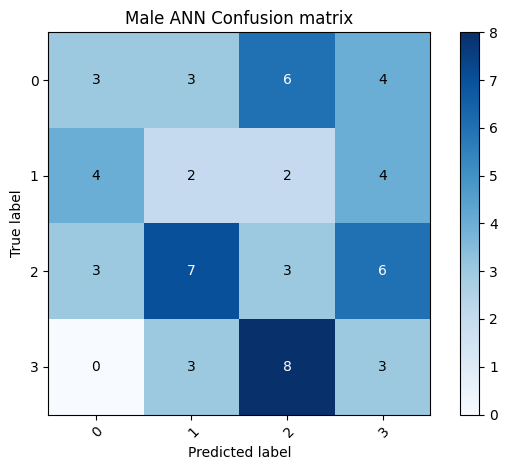

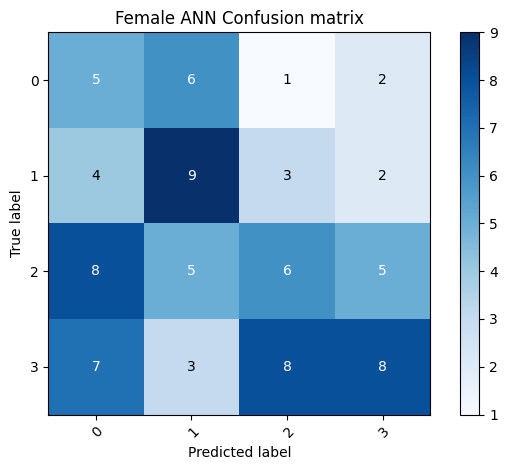

In [58]:
for s, p in zip(splitList, nn_predictions):
    plot_confusion_matrix(s[3], p, classes=['0', '1', '2', '3'], normalize=False, title=f'{returnGender(s)} ANN Confusion matrix')
    plt.show()

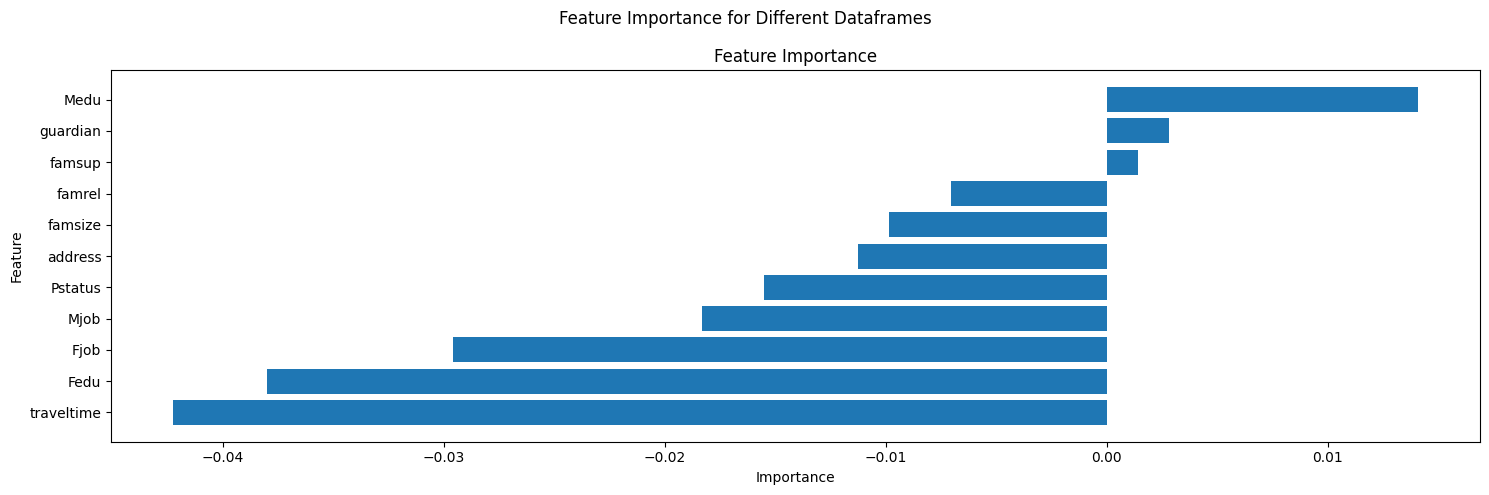

In [24]:
for s, m in zip(splitList, nn_models[1]):
    plot_feature_importance(m, extraTitle=returnGender(s))

#### TODO:
1. Træn alle modeller på kønsfordelingen
2. Se importance features på de nye modeller
3. Vælg de vigtige features og træn modeller igen
4. NB: vigtige features kan også udvælges fra eda visualiseringerne.